# **Transformer-based English to Russian AI**

In [1]:
import os
import re
import warnings
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers
print(
    tf.__version__, 
    tf.config.list_physical_devices('GPU'), # GPU required for this task
    keras.__version__
)

C:\Users\METABOX\miniconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


2.10.0 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 2.10.0


We will be using a text file provided by [Anki's Russian-English biligual sentence pairs](http://www.manythings.org/anki/) for this project. 


## **Data Preprocessings**
#### 1. Add `"[start]"` and `"[end]"` tokens to the Russian text

In [2]:
bilingual_file_dir = "rus.txt"
# this is a csv file containing English in the first column and Russian in the second

with open(bilingual_file_dir, encoding='utf-8') as f: 
    lines = f.read().split("\n")
text_pairs = []        
for line in lines:
    english, russian, _ = line.split("\t") # ignore the third column
    russian = "[start] " + russian + " [end]"
    text_pairs.append((english, russian))
    
print(len(text_pairs)) 

#### 2. Split the paired data into train/val/test groups

In [3]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(len(train_pairs), len(val_pairs), len(test_pairs))

487600


#### 3. Standardise sentences

In [5]:
def standardize(string):
    strip_chars = '"#$%&\'()*+,-./:;<=>@\\^_`{|}~—'
    # English and Russian largely share the same punctuation
    
    string = tf.strings.lower(string)
    
    string = tf.strings.regex_replace(string, f"[{re.escape(strip_chars)}]", "")
    # Remove characters in strip_chars using regular expression
    return string

#### 4. Set tokenisation parameters
`vocab_size`: the top *n* most frequent tokens in the training texts for both languages.
`sequence_length`: English and Russian sentences cannot exceed this many words. Words after this cap will be cut off.

In [4]:
vocab_size = 25_000
sequence_length = 20

#### 5. Index each word to build a vocabulary
`TextVectorization` on an example corpus:
* "I saw the red car."
* "The dog will bark at the car!"

After **standardisation**:
  * "i saw the red car"
  * "the dog will bark at the car"

After **tokenisation**:
  * ["i", "saw", "the", "red", "car"]
  * ["the", "dog", "will", "bark", "at", "the", "car"]

Each token is **replaced with a unique integer** ranging up to `vocab_size`, where '1' is the most frequent token in the corpus:
  * [3, 4, 1, 5, 2]
  * [1, 6, 7, 8, 9, 1, 2]

 
We will be doing this same process for Anki's 487,600 pairs of Russian-English sentences.

In [6]:
eng_vectorization = layers.TextVectorization( # maps text to integer sequences
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=standardize
)
rus_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # needs to be one step ahead
    standardize=standardize
)

train_english_texts = [pair[0] for pair in train_pairs]
train_russian_texts = [pair[1] for pair in train_pairs]

# the .adapt() method builds the vocabulary from input data
eng_vectorization.adapt(train_english_texts)
rus_vectorization.adapt(train_russian_texts)

rus_index_lookup = dict(enumerate(rus_vectorization.get_vocabulary()))
# {0: '', 1: '[UNK]', 2: '[start]', 3: '[end]', 4: 'Я', 5: 'не',... `vocab_size`-1: 'намереваешься'}

In [7]:
batch_size = 128 

def format_dataset(eng, rus):
    eng = eng_vectorization(eng)
    rus = rus_vectorization(rus)
    return (
        {"english": eng, "russian": rus[:, :-1]}, 
        # these dict keys will also be the model's Input layers' names
        rus[:, 1:]
    )
    # returns a tuple that will be the model's two inputs

def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    # # Slicing a tuple of 1D tensors produces tuple elements containing scalar tensors.

    dataset = dataset.batch(batch_size)
    
    dataset = dataset.map(format_dataset, num_parallel_calls=8)
    
    dataset = dataset.shuffle(2048).prefetch(16).cache()
    # uses in-memory caching to speed up preprocessing.
    return dataset

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

## **Architecture**

The transformer will the architecture as proposed in [Vaswani et al.'s "*Attention Is All You Need*"](https://arxiv.org/abs/1706.03762).

![Vaswini et. al](https://www.researchgate.net/publication/339390384/figure/fig1/AS:860759328321536@1582232424168/The-transformer-model-from-Attention-is-all-you-need-Viswani-et-al.jpg)

In [8]:
embed_dim = 256 # each embedded token is a vector of this length. 
#For ChatGPT, this value would be about 12,000

dense_dim = 1024
num_heads = 8

The `PositionalEmbedding` combines *two* different embeddings: 
* token embeddings, which regard each word's unique semantics
* position embeddings, which provide a unique embedding for each position in the sequence up to `sequence_length`. It ensures that the model can account for the order of tokens within the sequence.

Adding together those two embeddings integrates their information.

In [9]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def compute_mask(self, inputs, mask=None):
        # since sentences vary in length, shorter sentences will be padded
        # masking is to avoid considering padded positions
        
        return tf.math.not_equal(inputs, 0) # does not work on latest tf
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        embedded_tokens = self.token_embeddings(inputs) 
        embedded_positions = self.position_embeddings(positions)

        embeddeding = embedded_tokens + embedded_positions
        # combines position information with token representation
        
        return embeddeding  

    def get_config(self):
        config = super().get_config()
        config.update({
            'output_dim':self.output_dim,
            'sequence_length':self.sequence_length,
            'input_dim':self.input_dim,
        })
        return config

In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim # size of token vectors, also the key_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.multi_head_attention = layers.MultiHeadAttention(
        # for every attention head:
            # Q, K and V all have independent dense connections
            # Then, the dense projection's are inputted into attention
        # attention outputs of each head are concatenated together
            num_heads=num_heads,
            key_dim=embed_dim
        )
        
        self.layernorm_1 = layers.LayerNormalization()
        
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        
        self.layernorm_2 = layers.LayerNormalization()
        
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.multi_head_attention(
            inputs, inputs, attention_mask=mask
        )
        before_fc = self.layernorm_1(inputs + attention_output)
        after_fc  = self.dense_proj(before_fc)

        final_output = self.layernorm_2(before_fc + after_fc)

        return final_output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config  

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.supports_masking = True
        
        self.multi_head_attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        self.layernorm_1 = layers.LayerNormalization()
        
        self.multi_head_attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        self.layernorm_2 = layers.LayerNormalization()

        self.dense_proj  = keras.Sequential([
            layers.Dense(self.dense_dim, activation='relu'),
            layers.Dense(self.embed_dim)
        ])

        self.layernorm_3 = layers.LayerNormalization()

    def get_causal_attention_mask(self, inputs): # necessary to prevent information leakage from future timesteps
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        
        mask = tf.linalg.band_part( # returns lower triangle
            tf.ones((sequence_length,sequence_length)), -1, 0
        )
        mask = tf.cast(mask, 'int32')
        
        mask = tf.tile( # Replicate 100 times along the new axis
            mask[tf.newaxis, :, :], 
            
            [batch_size, 1, 1] 
        )
        return mask 
        # mask has shape: (batch_size, sequence_length, sequence_length)
        
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:,tf.newaxis,:], dtype='int32'
            )
            padding_mask = tf.minimum(padding_mask, causal_mask)
            
        multi_head_1_output = self.multi_head_attention_1(
            query=inputs, value=inputs, key=inputs, 
            attention_mask=causal_mask
        )

        layernorm_1_output = self.layernorm_1(
            inputs + multi_head_1_output
        )

        multi_head_attention_2_output = self.multi_head_attention_2(
            query=multi_head_1_output, value=encoder_outputs, key=encoder_outputs, 
            attention_mask=padding_mask
        )

        layernorm_2_output = self.layernorm_2(
            layernorm_1_output + multi_head_attention_2_output
        )

        dense_proj_output = self.dense_proj(
            layernorm_2_output
        )

        layernorm_3_output = self.layernorm_3(
            layernorm_2_output + dense_proj_output
        )
        return layernorm_3_output
             
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### Source sequence (English)

In [11]:
english_input_layer = keras.Input(
    shape=(None,), # transformers are shape invariant
    dtype="int64", 
    name="english"
)

english_embedding = PositionalEmbedding(
    sequence_length = sequence_length,
    input_dim = vocab_size, 
    output_dim = embed_dim, 
    name = 'english_embedding'
)(english_input_layer)

### Target sequence (russian)

In [12]:
russian_input_layer = keras.Input(
    shape=(None,), # transformers are shape invariant
    dtype="int64", 
    name = 'russian'
)

russian_embedding = PositionalEmbedding(
    sequence_length = sequence_length,
    input_dim = vocab_size, 
    output_dim = embed_dim, 
    name = 'russian_embedding'
)(russian_input_layer)

### Encoder

In [13]:
encoded_english = TransformerEncoder(
    embed_dim = embed_dim,
    dense_dim = dense_dim,
    num_heads = num_heads,
    name = 'encoder'
)(english_embedding)

### Decoder

In [14]:
x = TransformerDecoder(
    embed_dim=embed_dim,
    dense_dim=dense_dim,
    num_heads=num_heads
)(russian_embedding, encoder_outputs=encoded_english)

In [15]:
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(vocab_size, activation='softmax', name='output_layer')(x)

In [16]:
seq2seq_transformer = keras.Model(
    inputs = [english_input_layer, russian_input_layer],
    outputs= output_layer
)
print(seq2seq_transformer.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 russian (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 english_embedding (PositionalE  (None, None, 256)   6405120     ['english[0][0]']                
 mbedding)                                                                                        
                                                                                                  
 russian_embedding (PositionalE  (None, None, 256)   6405120     ['russian[0][0]']            

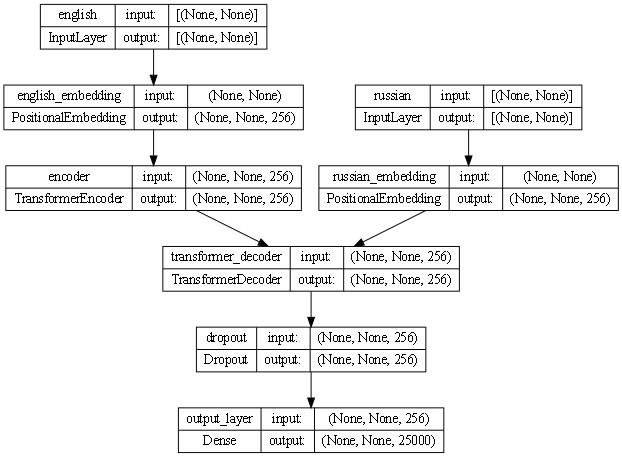

In [17]:
keras.utils.plot_model(seq2seq_transformer, show_shapes=True, show_layer_names=True, dpi=70)

## **Model Training**

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
)

seq2seq_transformer.compile(
    optimizer=optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"] # next token accuracy
)

seq2seq_transformer.fit(
    train_ds, 
    epochs=64, # may be stopped by EarlyStopping before reaching this number
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/64
2667/2667 [==============================] - 1057s 395ms/step - loss: 0.9090 - accuracy: 0.6003 - val_loss: 0.5379 - val_accuracy: 0.6997
Epoch 2/64
2667/2667 [==============================] - 1077s 404ms/step - loss: 0.5196 - accuracy: 0.7046 - val_loss: 0.4389 - val_accuracy: 0.7340
Epoch 3/64
2667/2667 [==============================] - 1080s 405ms/step - loss: 0.4192 - accuracy: 0.7391 - val_loss: 0.4059 - val_accuracy: 0.7480
Epoch 4/64
2667/2667 [==============================] - 1082s 406ms/step - loss: 0.3663 - accuracy: 0.7601 - val_loss: 0.3914 - val_accuracy: 0.7566
Epoch 5/64
2667/2667 [==============================] - 1078s 404ms/step - loss: 0.3314 - accuracy: 0.7758 - val_loss: 0.3865 - val_accuracy: 0.7618
Epoch 6/64
2667/2667 [==============================] - 1076s 403ms/step - loss: 0.3063 - accuracy: 0.7876 - val_loss: 0.3847 - val_accuracy: 0.7652
Epoch 7/64
2667/2667 [==============================] - 1073s 402ms/step - loss: 0.2865 - accuracy: 0.7973

In [19]:
keras.models.save_model(seq2seq_transformer,'eng_rus_translate.keras')

In [20]:
print(seq2seq_transformer.evaluate(test_ds, return_dict=True))

572/572 [==============================] - 106s 185ms/step - loss: 0.4230 - accuracy: 0.7752
{'loss': 0.42303743958473206, 'accuracy': 0.7751858830451965}


The 'accuracy' metric refers to predicting the next word in the sequence correctly. 

## **Manual Evaluation**
Firstly, need a way to see the examples of the sentences being translated. Then, 50 sample will be manually cross-checked with Google Translate and judged for their accuracy. 

In [28]:
def decode_sequence(
    input_sentence, 
    max_decoded_sentence_length = sequence_length
):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = rus_vectorization([decoded_sentence])
        
        predicted_next_token = seq2seq_transformer.predict(
            [tokenized_input_sentence, tokenized_target_sentence[:,:-1]], 
            verbose=0
        )
        
        sampled_token_index = np.argmax(predicted_next_token[0, i, :])
        sampled_token = rus_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

random.seed(0)
with open("translation_output.txt", "w") as file:
    for _ in range(50):
        decoded_sentence = "[UNK]"
        # continue fetching and decoding until a sentence without [UNK] is decoded
        while "[UNK]" in decoded_sentence:
            random_english_sentence_index = random.randint(0, num_val_samples - 1)
            input_sentence = test_pairs[random_english_sentence_index][0]
            decoded_sentence = decode_sequence(input_sentence)
        file.write(f"Original: {input_sentence}\n")
        file.write(f"Decoded: {decoded_sentence}\n\n")
        print(input_sentence)
        print(decoded_sentence)
        print()

Tom told Mary he needed her help.
[start] Том сказал Мэри что ему нужна её помощь [end]

Do you like opera?
[start] Ты любишь оперу? [end]

We adopted a baby.
[start] Мы усыновили ребёнка [end]

Could you talk a little slower?
[start] Ты не могла бы говорить немного помедленнее? [end]

I don't think I'll be able to eat all this.
[start] Не думаю что смогу это всё съесть [end]

The police are going to catch you sooner or later.
[start] Полиция рано или поздно тебя поймает [end]

Tom was aware that Mary was married.
[start] Том был в курсе что Мэри замужем [end]

Tom makes about fifty phone calls a day.
[start] Том делает пять звонков телефона [end]

I don't want to talk about it right now.
[start] Я не хочу сейчас об этом говорить [end]

Please don't do anything else.
[start] Пожалуйста не делай ничего ещё [end]

Tom wants to go with us.
[start] Том хочет пойти с нами [end]

I really don't know what to say.
[start] Я правда не знаю что сказать [end]

You need me.
[start] Я вам нужен [en

#### 48* of 50 correct!
_Translations with minor grammatical errors counted as correct if the meaning was preserved._

The two incorrectly translated sentences were:
* "John took a key from his pocket" to **"Том достал из кармана ключ"**
    * "John" was incorrectly translated as "Tom," because "Tom" is a frequently used name in the training data.
* "Tom makes about fifty phone calls a day." to **"Том делает пять звонков телефона"**
    * Missing "about" and "a day," and used the wrong case for "телефона."
 
Minor errors in tense, gender, or case also occurred, probably due to the training data not being comprehensive enough to capture contextual nuances of grammatical forms.

To enhance translation quality in future similar projects, it's crucial to use a more diverse training dataset covering various language styles and contexts. Additionally, increasing computational capabilities, such as expanding embedding dimensions and adding more attention heads, will help the model better manage complex language structures. These upgrades will improve the model's grammatical accuracy and overall translation quality.